<a href="https://colab.research.google.com/github/ali3brt/20-Newsgroups-Dataset/blob/main/01_CLIP_VIT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install transformers torch torchvision


In [5]:
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import torch

# Load the CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")


In [6]:
# Load example images
images = [
    Image.open("cat.jpg"),
    Image.open("car.jpg"),
    Image.open("bike.jpg")
]

# Example text prompts
prompts = [
    "A cat sitting on a sofa.",
    "A car driving on a road.",
    "A person riding a bicycle."
]


In [7]:
# Preprocess the images and text prompts
inputs = processor(text=prompts, images=images, return_tensors="pt", padding=True)

# Extract text and image embeddings
outputs = model(**inputs)
image_embeddings = outputs.image_embeds  # Embeddings for images
text_embeddings = outputs.text_embeds    # Embeddings for text


In [8]:
import torch.nn.functional as F

# Calculate cosine similarity between each image and each text prompt
cosine_similarities = F.cosine_similarity(
    image_embeddings.unsqueeze(1),  # Shape: [num_images, 1, embedding_dim]
    text_embeddings.unsqueeze(0),   # Shape: [1, num_texts, embedding_dim]
    dim=-1
)

# Print the similarity matrix
print("Cosine Similarities between Images and Text Prompts:\n", cosine_similarities)


Cosine Similarities between Images and Text Prompts:
 tensor([[0.3228, 0.1732, 0.1844],
        [0.0792, 0.2685, 0.1855],
        [0.0750, 0.1916, 0.3066]], grad_fn=<SumBackward1>)


In [9]:
# Find the best matching prompt for each image
best_matches = torch.argmax(cosine_similarities, dim=1)
for idx, match in enumerate(best_matches):
    print(f"Image {idx + 1} is best matched with prompt: '{prompts[match]}'")


Image 1 is best matched with prompt: 'A cat sitting on a sofa.'
Image 2 is best matched with prompt: 'A car driving on a road.'
Image 3 is best matched with prompt: 'A person riding a bicycle.'


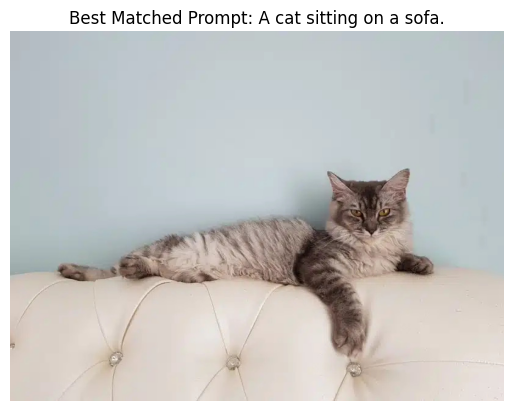

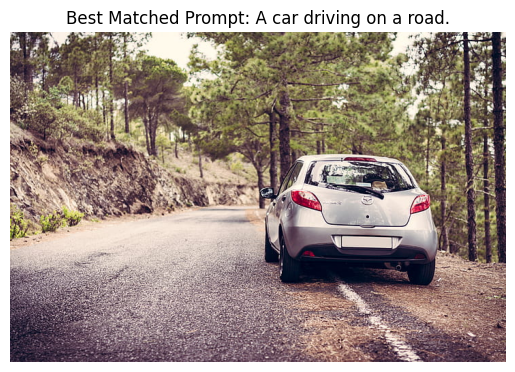

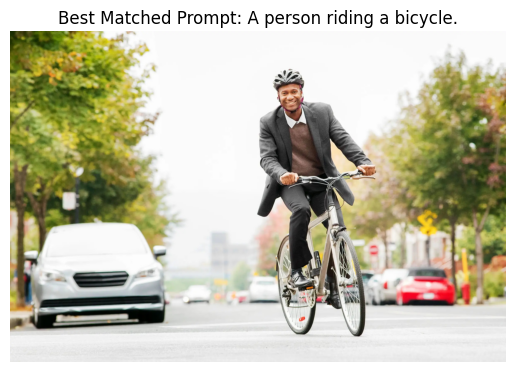

In [10]:
import matplotlib.pyplot as plt

# Plot the images with their best matched text prompt
for idx, image in enumerate(images):
    plt.imshow(image)
    plt.title(f"Best Matched Prompt: {prompts[best_matches[idx]]}")
    plt.axis("off")
    plt.show()


In [11]:
from transformers import ViTFeatureExtractor, ViTForImageClassification
model = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224")
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [12]:
# Load example images
images = [
    Image.open("cat.jpg").convert('RGB'),
    Image.open("car.jpg").convert('RGB'),
    Image.open("bike.jpg").convert('RGB')
]


In [13]:
# Preprocess images
inputs = feature_extractor(images=images, return_tensors="pt")


In [14]:
# Perform inference
with torch.no_grad():
    outputs = model(**inputs)
    logits = outputs.logits

# Get predicted classes
predicted_class_indices = torch.argmax(logits, dim=-1)
print("Predicted Class Indices:", predicted_class_indices)


Predicted Class Indices: tensor([285, 479, 444])


In [15]:
# Map predicted class indices to labels
labels = model.config.id2label
for idx, predicted_index in enumerate(predicted_class_indices):
    print(f"Image {idx + 1} is predicted as: {labels[predicted_index.item()]}")


Image 1 is predicted as: Egyptian cat
Image 2 is predicted as: car wheel
Image 3 is predicted as: bicycle-built-for-two, tandem bicycle, tandem


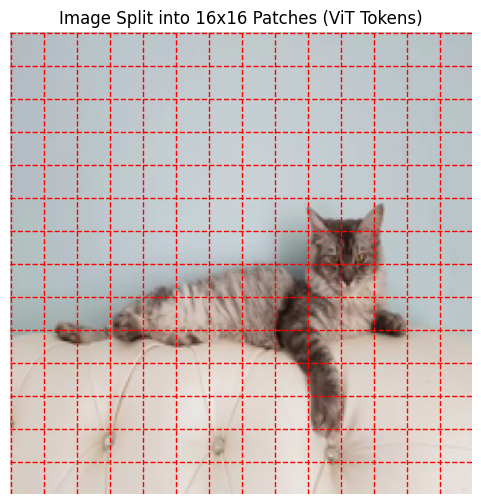

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

# Load an example image
image = Image.open("cat.jpg").convert("RGB")
image = image.resize((224, 224))  # Resize the image to 224x224 (ViT input size)

# Convert the image to a numpy array
image_np = np.array(image)

# Define the patch size (16x16) and stride
patch_size = 16

# Visualize the patch grid on the image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(image_np)

# Draw grid lines to represent patches
for i in range(0, image_np.shape[1], patch_size):
    ax.axvline(i, color='red', linestyle='--', linewidth=1)
for j in range(0, image_np.shape[0], patch_size):
    ax.axhline(j, color='red', linestyle='--', linewidth=1)

ax.set_title("Image Split into 16x16 Patches (ViT Tokens)")
ax.axis('off')
plt.show()


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
`ViTSdpaAttention` is used but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


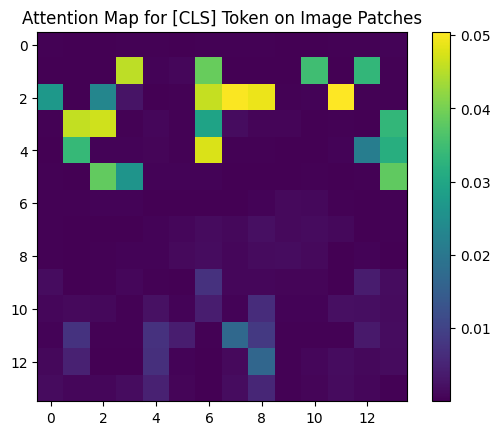

In [17]:
from transformers import ViTModel
import torch

# Load the pretrained ViT model (without classification head, for extracting features)
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224", output_attentions=True)

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Get the model outputs with attention maps
with torch.no_grad():
    outputs = vit_model(**inputs)

# Extract the attention weights
attentions = outputs.attentions  # This will be a tuple of attention weights from each layer

# Choose a specific layer and head for visualization
layer_idx = -1  # Last layer
head_idx = 0  # First attention head in the layer

# Get the attention map for a specific head
attention_map = attentions[layer_idx][0, head_idx]  # Shape: [num_tokens, num_tokens]

# Visualize the attention map for the [CLS] token
cls_attention = attention_map[0, 1:]  # Remove the [CLS] token's self-attention
cls_attention = cls_attention.view(14, 14)  # Reshape to (14, 14), since we have 196 patches

plt.imshow(cls_attention.numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Map for [CLS] Token on Image Patches")
plt.show()


Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


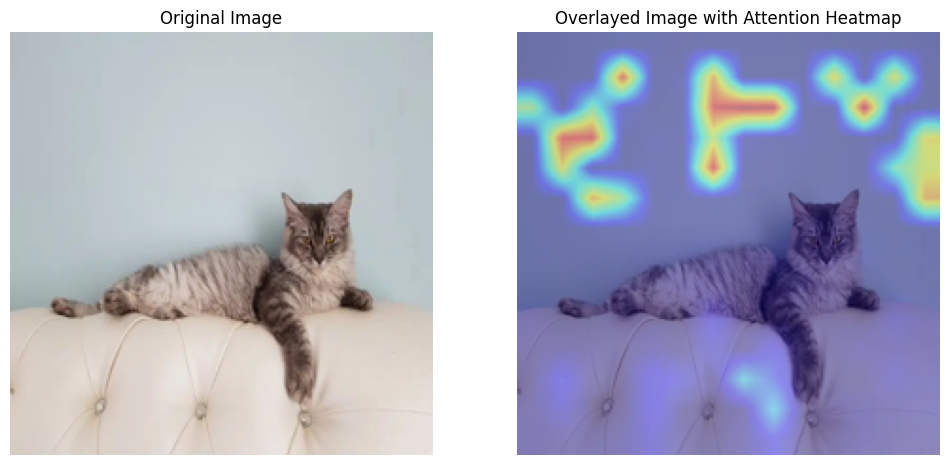

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from transformers import ViTModel, ViTFeatureExtractor
import torch
import torch.nn.functional as F

# Load the image and the ViT model
image = Image.open("cat.jpg").convert("RGB")
image = image.resize((224, 224))  # Resize the image to 224x224 (ViT input size)
vit_model = ViTModel.from_pretrained("google/vit-base-patch16-224", output_attentions=True)
feature_extractor = ViTFeatureExtractor.from_pretrained("google/vit-base-patch16-224")

# Preprocess the image
inputs = feature_extractor(images=image, return_tensors="pt")

# Get the model outputs with attention maps
with torch.no_grad():
    outputs = vit_model(**inputs)

# Extract the attention weights from the last layer, first attention head
attentions = outputs.attentions  # Tuple of attention weights from all layers
layer_idx = -1  # Last layer
head_idx = 0  # First attention head
attention_map = attentions[layer_idx][0, head_idx]  # Shape: [num_tokens, num_tokens]

# Get the attention map for the [CLS] token, reshape it to (14, 14)
cls_attention = attention_map[0, 1:]  # Remove self-attention of [CLS]
cls_attention = cls_attention.view(14, 14)  # Reshape to (14, 14)

# Normalize the attention map to 0-1
cls_attention = cls_attention.numpy()
cls_attention = (cls_attention - cls_attention.min()) / (cls_attention.max() - cls_attention.min())

# Resize the attention map to match the size of the original image (224x224)
cls_attention_resized = Image.fromarray(np.uint8(cls_attention * 255)).resize((224, 224), Image.BILINEAR)
cls_attention_resized = np.array(cls_attention_resized) / 255.0  # Normalize to 0-1 again

# Convert the original image to a numpy array
image_np = np.array(image) / 255.0

# Overlay the attention map on the original image
# Blend the image and attention map, using a red heatmap to emphasize attention
heatmap = plt.get_cmap('jet')(cls_attention_resized)[:, :, :3]  # Get RGB from the 'jet' colormap
overlayed_image = 0.6 * image_np + 0.4 * heatmap  # Adjust the weights to control blending

# Display the original image and overlayed image
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_np)
ax[0].set_title("Original Image")
ax[0].axis('off')

ax[1].imshow(overlayed_image)
ax[1].set_title("Overlayed Image with Attention Heatmap")
ax[1].axis('off')

plt.show()
